<a href="https://colab.research.google.com/github/pikey-msc/AprendizMaquina/blob/main/2023-1/SVM/SMV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Carga de información GITHUB

In [1]:
try:
    !rm -rf CursoDF
except:
    print("No existe la ruta aún")

!git clone "https://github.com/pikey-msc/CursoDF"

Cloning into 'CursoDF'...
remote: Enumerating objects: 246, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 246 (delta 3), reused 0 (delta 0), pack-reused 232
Receiving objects: 100% (246/246), 19.70 MiB | 4.43 MiB/s, done.
Resolving deltas: 100% (118/118), done.


#Carga de librerías

In [2]:
#Cargar módulo de R en Python
# A bit of imports
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# Load in the r magic
%reload_ext rpy2.ipython
%config IPCompleter.greedy=True
%config InlineBackend.figure_format = 'retina'

In [4]:
%%R
#install.packages("dplyr")
library(dplyr) # "Libreria utilizada para manejar datos"
library(rpart)
# install.packages("rpart.plot")
# library(rpart.plot)
install.packages("caret")
library(caret)
install.packages("e1071")
library(e1071)
install.packages("ModelMetrics")
library(ModelMetrics)
# install.packages("party")
# library(party)
# install.packages("boot")
# library(boot)
# install.packages("ipred")
# library(ipred)
# install.packages("randomForest")
# library(randomForest)
library(ggplot2)
install.packages("ISLR")
library(ISLR)



Attaching package: ‘dplyr’



    filter, lag



    intersect, setdiff, setequal, union


(as ‘lib’ is unspecified)







	‘/tmp/Rtmp6Lgp0W/downloaded_packages’



(as ‘lib’ is unspecified)







	‘/tmp/Rtmp6Lgp0W/downloaded_packages’

(as ‘lib’ is unspecified)







	‘/tmp/Rtmp6Lgp0W/downloaded_packages’

Attaching package: ‘ModelMetrics’



    confusionMatrix, precision, recall, sensitivity, specificity



    kappa


(as ‘lib’ is unspecified)







	‘/tmp/Rtmp6Lgp0W/downloaded_packages’



#Máquinas de Soporte Vectorial (*Support Vector Machine*)

**Introducción**

El método de clasificación-regresión Máquinas de Vector Soporte (Support Vector Machines, SVMs) fue desarrollado en la década de los 90, dentro de campo de la ciencia computacional. Si bien originariamente se desarrolló como un método de clasificación binaria, su aplicación se ha extendido a problemas de clasificación múltiple y regresión. SVMs ha resultado ser uno de los mejores clasificadores para un amplio abanico de situaciones, por lo que se considera uno de los referentes dentro del ámbito de aprendizaje estadístico y machine learning.

Las Máquinas de Vector Soporte se fundamentan en el Maximal Margin Classifier, que a su vez, se basa en el concepto de hiperplano. A lo largo de este ensayo se introducen por orden cada uno de estos conceptos. Comprender los fundamentos de las SVMs requiere de conocimientos sólidos en álgebra lineal. En este ensayo no se profundiza en el aspecto matemático, pero puede encontrarse una descripción detallada en el libro Support Vector Machines Succinctly by Alexandre Kowalczyk

En R, las librerías ``e1071`` y ``LiblineaR`` contienen los algoritmos necesarios para obtener modelos de clasificación simple, múltiple y regresión, basados en Support Vector Machines.

**Hiperplano y Maximal Margin Classifier**


En un espacio $p$-dimensional, un hiperplano se define como un subespacio plano y afín de dimensiones $p−1$. El término afín significa que el subespacio no tiene por qué pasar por el origen. En un espacio de dos dimensiones, el hiperplano es un subespacio de 1 dimensión, es decir, una recta. En un espacio tridimensional, un hiperplano es un subespacio de dos dimensiones, un plano convencional. Para dimensiones p>3 no es intuitivo visualizar un hiperplano, pero el concepto de subespacio con $p−1$ dimensiones se mantiene.

La definición matemática de un hiperplano es bastante simple. En el caso de dos dimensiones, el hiperplano se describe acorde a la ecuación de una recta:
$$\beta_0 + \beta_1x_1 + \beta_2x_2 = 0$$


Dados los parámetros $β_0$, $β_1$ y $β_2$, todos los pares de valores $x=(x_1,x_2)$ para los que se cumple la igualdad son puntos del hiperplano. Esta ecuación puede generalizarse para $p$-dimensiones:
$$\beta_0 + \beta_1x_1 + \beta_2x_2 + ... + \beta_px_p = 0$$
y de igual manera, todos los puntos definidos por el vector $(x=x_1,x_2,...,x_p)$ que cumplen la ecuación pertenecen al hiperplano.

Cuando $x$ no satisface la ecuación:
$$\beta_0 + \beta_1x_1 + \beta_2x_2 + ... + \beta_px_p < 0$$
o bien 
$$\beta_0 + \beta_1x_1 + \beta_2x_2 + ... + \beta_px_p > 0$$

el punto $x$ cae a un lado o al otro del hiperplano. Así pues, se puede entender que un hiperplano divide un espacio $p$-dimensional en dos mitades. Para saber en qué lado del hiperplano se encuentra un determinado punto $x$, solo hay que calcular el signo de la ecuación.

La siguiente imagen muestra el hiperplano de un espacio bidimensional. La ecuación que describe el hiperplano (una recta) es $1+2x_1+3x_2=0$. La región azul representa el espacio en el que se encuentran todos los puntos para los que $1+2x_1+3x_2>0$ y la región roja el de los puntos para los que $1+2x_1+3x_2<0$.


<div class="figure">
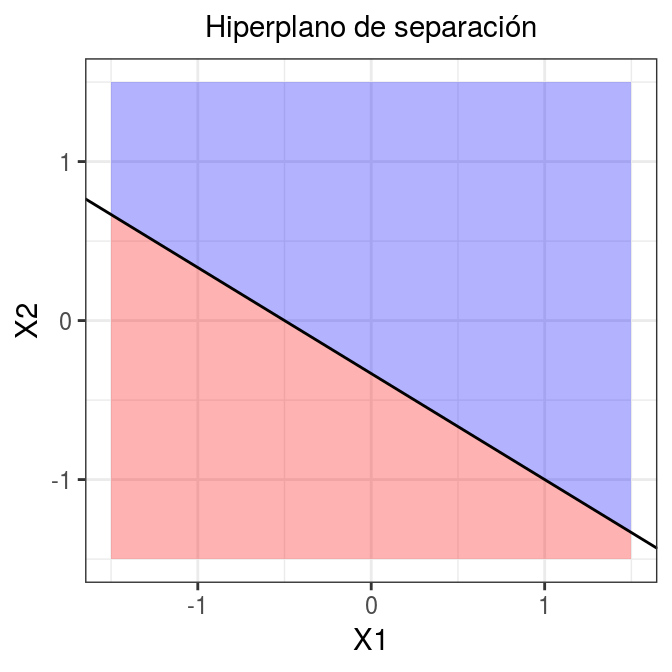

**Clasificación binaria empleando un hiperplano**


Cuando se dispone de $n$ observaciones, cada una con $p$ predictores y cuya variable respuesta tiene dos niveles (de aquí en adelante identificados como $+1$ y $−1$), se pueden emplear hiperplanos para construir un clasificador que permita predecir a que grupo pertenece una observación en función de sus predictores. Este mismo problema puede abordarse también con otros métodos (regresión logística, LDA, árboles de clasificación…) cada uno con ventajas y desventajas.

Para facilitar la comprensión, las siguientes explicaciones se basan en un espacio de dos dimensiones, donde un hiperplano es una recta. Sin embargo, los mismos conceptos son aplicables a dimensiones superiores.

**CASOS PERFECTAMENTE SEPARABLES LINEALMENTE**

Si la distribución de las observaciones es tal que se pueden separar linealmente de forma perfecta en las dos clases ($+1$ y $−1$), entonces, un hiperplano de separación cumple que:
$$\beta_0 + \beta_1x_1 + \beta_2x_2 + ... + \beta_px_p > 0, \ si \ y_i=1$$
$$\beta_0 + \beta_1x_1 + \beta_2x_2 + ... + \beta_px_p < 0, \ si \ y_i=-1$$

Al identificar cada clase como $+1$ o $−1$, y dado que multiplicar dos valores negativos resultan en un valor positivo, las dos condiciones anteriores pueden simplificarse en una única:
$$y_i(\beta_0 + \beta_1x_1 + \beta_2x_2 + ... + \beta_px_p) > 0, \ \textrm{ para } \ i = 1 ... n$$

Bajo este escenario, el clasificador más sencillo consiste en asignar cada observación a una clase dependiendo del lado del hiperplano en el que se encuentre. Es decir, la observación $\textbf{$x^*$}$ se clasifica acorde al signo de la función $f(\textbf{$x^\ast$}) = \beta_0 + \beta_1x^\ast_1 + \beta_2x^\ast_2 + ... + \beta_px^\ast_p$. Si $f(x^\ast)$ es positiva, la observación se asigna a la clase $+1$, si es negativa, a la clase $−1$. Además, la magnitud de $f(x^\ast)$ permite saber cómo de lejos está la observación del hiperplano y con ello la confianza de la clasificación.

La definición de hiperplano para casos perfectamente separables linealmente resulta en un número infinito de posibles hiperplanos, lo que hace necesario un método que permita seleccionar uno de ellos como clasificador óptimo.


<div class="figure">
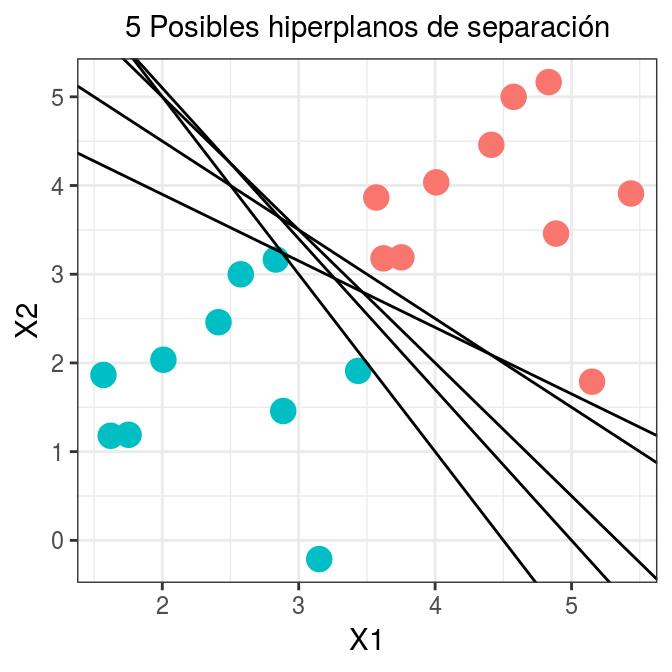

La solución a este problema consiste en seleccionar como clasificador óptimo al que se conoce como *maximal margin hyperplane o hiperplano óptimo de separación*, que se corresponde con el hiperplano que se encuentra más alejado de todas las observaciones de entrenamiento. Para obtenerlo, se tiene que calcular la distancia perpendicular de cada observación a un determinado hiperplano. La menor de estas distancias (conocida como margen) determina como de alejado está el hiperplano de las observaciones de entrenamiento. El maximal margin hyperplane se define como el hiperplano que consigue un mayor margen, es decir, que la distancia mínima entre el hiperplano y las observaciones es lo más grande posible. Aunque esta idea suena razonable, no es posible aplicarla, ya que habría infinitos hiperplanos contra los que medir las distancias. En su lugar, se recurre a métodos de optimización. Para encontrar una descripción más detallada de la solución por optimización consultar (*Support Vector Machines Succinctly by Alexandre Kowalczyk*).

<div class="figure">
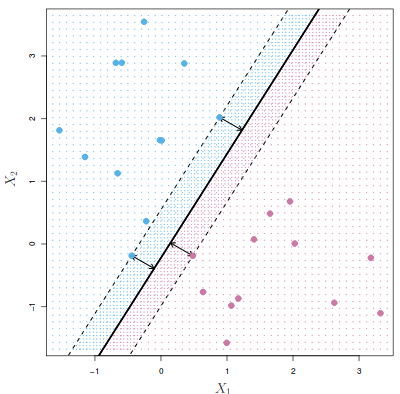


La imagen anterior muestra el maximal margin hyperplane para un conjunto de datos de entrenamiento. Las tres observaciones equidistantes respecto al maximal margin hyperplane se encuentran a lo largo de las líneas discontinuas que indican la anchura del margen. A estas observaciones se les conoce como vectores soporte, ya que son vectores en un espacio p-dimensional y soportan (definen) el maximal margin hyperplane. Cualquier modificación en estas observaciones (vectores soporte) conlleva cambios en el maximal margin hyperplane. Sin embargo, modificaciones en observaciones que no son vector soporte no tienen impacto alguno en el hiperplano.

*CASOS CUASI-SEPARABLES LINEALMENTE*

El maximal margin hyperplane descrito en el apartado anterior es una forma muy simple y natural de clasificación siempre y cuando exista un hiperplano de separación. En la gran mayoría de casos reales, los datos no se pueden separar linealmente de forma perfecta, por lo que no existe un hiperplano de separación y no puede obtenerse un maximal margin hyperplane.

<div class="figure">
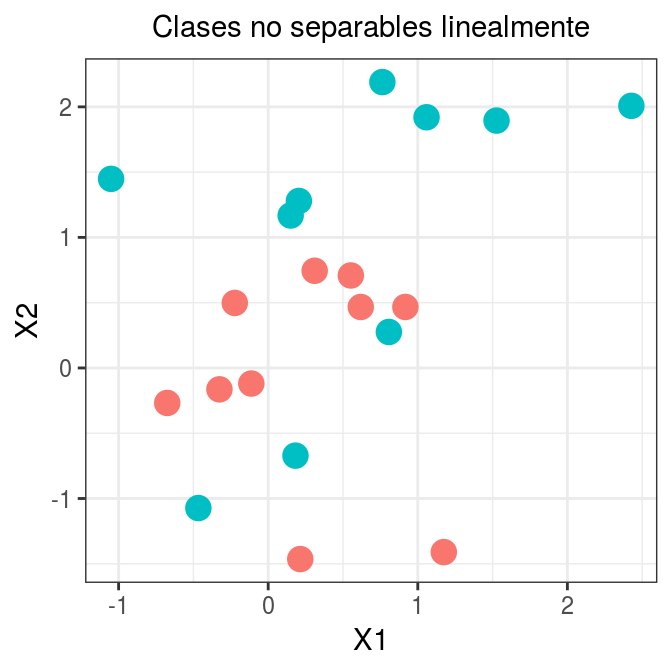


Para solucionar estas situaciones, se puede extender el concepto de *maximal margin hyperplane* para obtener un hiperplano que casi separe las clases, pero permitiendo que cometa unos pocos errores. A este tipo de hiperplano se le conoce como *Support Vector Classifier o Soft Margin*

##Support Vector Classifier o Soft Margin SVM


El Maximal Margin Classifier descrito en la sección anterior tiene poca aplicación práctica, ya que rara vez se encuentran casos en los que las clases sean perfecta y linealmente separables. De hecho, incluso cumpliéndose estas condiciones ideales, en las que exista un hiperplano capaz de separar perfectamente las observaciones en dos clases, esta aproximación sigue presentando dos inconvenientes:

Dado que el hiperplano tiene que separar perfectamente las observaciones, es muy sensible a variaciones en los datos. Incluir una nueva observación puede suponer cambios muy grandes en el hiperplano de separación (poca robustez).

Que el maximal margin hyperplane se ajuste perfectamente a las observaciones de entrenamiento para separarlas todas correctamente suele conllevar problemas de overfitting.

Por estas razones, es preferible crear un clasificador basado en un hiperplano que, aunque no separe perfectamente las dos clases, sea más robusto y tenga mayor capacidad predictiva al aplicarlo a nuevas observaciones (menos problemas de overfitting). Esto es exactamente lo que consiguen los clasificadores de vector soporte, también conocidos como soft margin classifiers o Support Vector Classifiers. Para lograrlo, en lugar de buscar el margen de clasificación más ancho posible que consigue que las observaciones estén en el lado correcto del margen; se permite que ciertas observaciones estén en el lado incorrecto del margen o incluso del hiperplano.

La siguiente imagen muestra un clasificador de vector soporte ajustado a un pequeño set de observaciones. La línea continua representa el hiperplano y las líneas discontinuas el margen a cada lado. Las observaciones 2, 3, 4, 5, 6, 7 y 10 se encuentran en el lado correcto del margen (también del hiperplano) por lo que están bien clasificadas. Las observaciones 1 y 8, a pesar de que se encuentran dentro del margen, están en el lado correcto del hiperplano, por lo que también están bien clasificadas. Las observaciones 11 y 12, se encuentran en el lado erróneo del hiperplano, su clasificación es incorrecta. Todas aquellas observaciones que, estando dentro o fuera del margen, se encuentren en el lado incorrecto del hiperplano, se corresponden con observaciones de entrenamiento mal clasificadas.

<div class="figure">
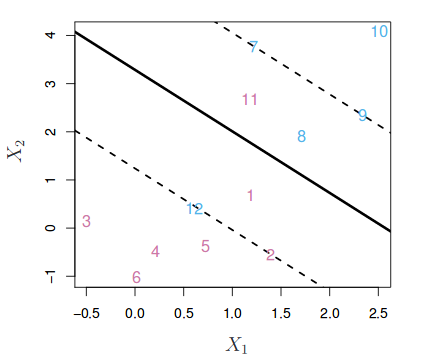


La identificación del hiperplano de un clasificador de vector soporte, que clasifique correctamente la mayoría de las observaciones a excepción de unas pocas, es un problema de optimización convexa. Si bien la demostración matemática queda fuera del objetivo de esta introducción, es importante mencionar que el proceso incluye un hiperparámetro de tuning $C$. $C$ controla el número y severidad de las violaciones del margen (y del hiperplano) que se toleran en el proceso de ajuste. Si $C=\infty$, no se permite ninguna violación del margen y por lo tanto, el resultado es equivalente al Maximal Margin Classifier (teniendo en cuenta que esta solución solo es posible si las clases son perfectamente separables). Cuando más se aproxima $C$ a cero, menos se penalizan los errores y más observaciones pueden estar en el lado incorrecto del margen o incluso del hiperplano. $C$ es a fin de cuentas el hiperparámetro encargado de controlar el balance entre bias y varianza del modelo. En la práctica, su valor óptimo se identifica mediante cross-validation.

El proceso de optimización tiene la peculiaridad de que solo las observaciones que se encuentran justo en el margen o que lo violan influyen sobre el hiperplano. A estas observaciones se les conoce como vectores soporte y son las que definen el clasificador obtenido. Esta es la razón por la que el parámetro $C$ controla el balance entre bias y varianza. Cuando el valor de $C$ es pequeño, el margen es más ancho, y más observaciones violan el margen, convirtiéndose en vectores soporte. El hiperplano está, por lo tanto, sustentado por más observaciones, lo que aumenta el bias pero reduce la varianza. Cuando mayor es el valor de $C$, menor el margen, menos observaciones serán vectores soporte y el clasificador resultante tendrá menor bias pero mayor varianza.

Otra propiedad importante que deriva de que el hiperplano dependa únicamente de una pequeña proporción de observaciones (vectores soporte), es su robustez frente a observaciones muy alejadas del hiperplano. Esto hace al método de clasificación vector soporte distinto a otros métodos tales como Linear Discrimiant Analysis (LDA), donde la regla de clasificación depende de la media de todas las observaciones.

<p>Dados vectores <span class="math notranslate nohighlight">\(x_i \in \mathbb{R}^p\)</span>, $i=1,…, n$, en dos clases, y un
vector <span class="math notranslate nohighlight">\(y \in \{1, -1\}^n\)</span>, el objetivo es encontrar <span class="math notranslate nohighlight">\(w \in
\mathbb{R}^p\)</span> y <span class="math notranslate nohighlight">\(b \in \mathbb{R}\)</span> tal que la predicción dada por
<span class="math notranslate nohighlight">\(\text{sign} (w^T\phi(x) + b)\)</span> sea correcta en todos los ejempplos.</p>
<p>SVC resuelve el siguiente problema:</p>
<div class="math notranslate nohighlight">
 \begin{align}\begin{aligned}\min_ {w, b, \zeta} \frac{1}{2} w^T w + C \sum_{i=1}^{n} \zeta_i\\\begin{split}\textrm {sujeto a } & y_i (w^T \phi (x_i) + b) \geq 1 - \zeta_i,\\
& \zeta_i \geq 0, i=1, ..., n\end{split}\end{aligned}\end{align} </div>
<p>Intuitivamente se trata de maximizar el margen (minimizando
<span class="math notranslate nohighlight">\(||w||^2 = w^Tw\)</span>), mientras se toma en cuenta la penalización cuando una parte de la muestra es mal clasificada o dentro de los límites del margen. Idealmente, el valor <span class="math notranslate nohighlight">\(y_i
(w^T \phi (x_i) + b)\)</span> debe ser <span class="math notranslate nohighlight">\(\geq 1\)</span> para todas las muestras, lo que indica una predicción perfecta. Pero sabemos que no todos los problemas son perfectamente separables con un hiperplano, por lo que se tienen algunas muestras que se dejan "malclasificar". El término de penalización <code class="docutils literal notranslate"><span class="pre">C</span></code> 
controla la rigidez de esta penalización, y actua como parámetro de regularización.

### Ejemplo

Para mostrar el uso de un Support Vector Classifier como clasificador binario, se simulan observaciones en un espacio bidimensional que pertenecen a dos clases. Este ejemplo se ha obtenido de los videos asociados al libro Introduction to Statistical Learning, que no es igual al presentado en el libro.

En los siguientes ejemplos, se emplea la función ``svm()`` contenida en el paquete ``e1071``. Esta función ajusta Support Vector Classifier si se le especifica el argumento ``kernel="linear"`` (como se describe más adelante, el método de Support Vector Machines es equivalente al Support Vector Classifier cuando el kernel utilizado es lineal). El argumento cost determina la penalización aplicada por violar el margen, es el nombre que emplea esta función para el hiperparámetro $C$.

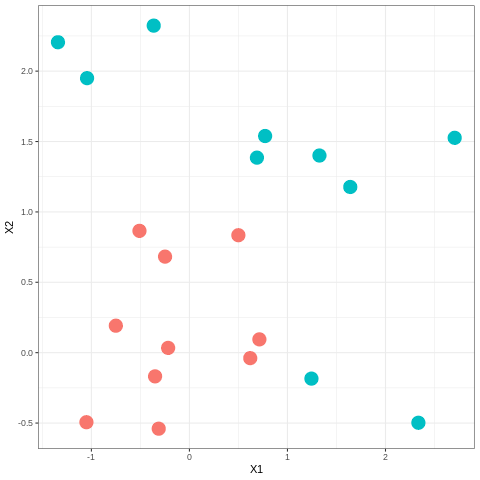

In [5]:
%%R
set.seed(10111)
coordenadas <- matrix(rnorm(40), 20, 2)
colnames(coordenadas) <- c("X1","X2")
y <- c(rep(-1,10), rep(1,10))
coordenadas[y == 1, ] <- coordenadas[y == 1, ] + 1
datos <- data.frame(coordenadas, y)
ggplot(data = datos, aes(x = X1, y = X2, color = as.factor(y))) +
  geom_point(size = 6) +
  theme_bw() +
  theme(legend.position = "none")

La representación gráfica de los datos muestra que los grupos no son linealmente separables.

La función ``svm()`` identifica automáticamente si se trata de un problema de clasificación, la variable respuesta es de tipo factor, o de regresión, la variable respuesta es tipo numérico.

In [7]:
%%R
# Se convierte la variable respuesta a factor
datos$y <- as.factor(datos$y)

# Para que la función svm() calcule el Support Vector Classifier,
# se tiene que indicar que la función kernel es lineal.
modelo_svm <- svm(formula = y ~ X1 + X2, data = datos, kernel = "linear",
                  cost = 10, scale = FALSE)

IMPORTANTE: En este caso, ambos predictores (X1, X2) tienen la misma escala por lo que no es necesario estandarizarlos. En aquellas situaciones en las que las escalas son distintas, sí hay que estandarizarlos, de lo contrario, los predictores de mayor magnitud eclipsarán a los de menor magnitud.

El ``summary`` del modelo muestra que hay un total de 6 vectores soporte, 3 pertenecen a una clase y 3 a la otra.

In [ ]:
%%R
print(summary(modelo_svm))
# Índice de las observaciones que actúan como vector soporte
modelo_svm$index


Call:
svm(formula = y ~ X1 + X2, data = datos, kernel = "linear", cost = 10, 
    scale = FALSE)


Parameters:
   SVM-Type:  C-classification 
 SVM-Kernel:  linear 
       cost:  10 

Number of Support Vectors:  6

 ( 3 3 )


Number of Classes:  2 

Levels: 
 -1 1



[1]  1  4 10 14 16 20


           [,1]
[1,]  10.000000
[2,]  10.000000
[3,]   4.713167
[4,]  -4.713167
[5,] -10.000000
[6,] -10.000000
[1] -2.403917
[1]  1  4 10 14 16 20
             X1          X2
[1,]  0.4992207  0.83459057
[2,]  0.7136758  0.09454017
[3,] -0.2485535  0.68234694
[4,]  2.3354574 -0.49779748
[5,]  1.2445945 -0.18418390
[6,] -1.0440209  1.95016425
       X1        X2 
-2.055647 -2.806278 
[1] -2.403917


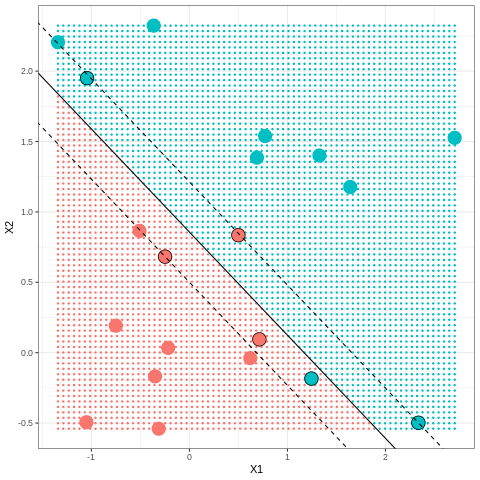

In [20]:
%%R
# SI AL AJUSTAR EL MODELO SE INDICA scale = true, SE TIENEN QUE ESTANDARIZAR
# TAMBIÉN LAS OBSERVACIONES PARA QUE COINCIDAN LAS COORDENADAS.

# Se interpolar puntos dentro del rango de los dos predictores X1 y X2.
# Estos nuevos puntos se emplean para predecir la variable respuesta acorde
# al modelo y así colorear las regiones que separa el hiperplano.

# Rango de los predictores
rango_X1 <- range(datos$X1)
rango_X2 <- range(datos$X2)

# Interpolación de puntos
new_x1 <- seq(from = rango_X1[1], to = rango_X1[2], length = 75)
new_x2 <- seq(from = rango_X2[1], to = rango_X2[2], length = 75)
nuevos_puntos <- expand.grid(X1 = new_x1, X2 = new_x2)

# Predicción según el modelo
predicciones <- predict(object = modelo_svm, newdata = nuevos_puntos)

# Se almacenan los puntos predichos para dar color a las regiones
color_regiones <- data.frame(nuevos_puntos, y = predicciones)

# Para extraer la ecuación del hiperplano y del margen es necesario aplicar 
# algebra lineal.
beta <- drop(t(modelo_svm$coefs) %*% as.matrix(datos[,c("X1","X2")])[modelo_svm$index,])
print(modelo_svm$coefs)
beta0 <- modelo_svm$rho
print(modelo_svm$rho)
print(modelo_svm$index) #observaciones del hiperplano
print(as.matrix(datos[,c("X1","X2")])[modelo_svm$index,])#observaciones del hiperplano
#print(head(datos))
print(beta)
print(beta0)

ggplot() +
  # Representación de las 2 regiones empleando los puntos y coloreándolos
  # según la clase predicha por el modelo
  geom_point(data = color_regiones, aes(x = X1, y = X2, color = as.factor(y)),
             size = 0.5) +
  # Se añaden las observaciones
  geom_point(data = datos, aes(x = X1, y = X2, color = as.factor(y)),
             size = 6) +
  # Se identifican aquellas observaciones que son vectores soporte del modelo
  geom_point(data = datos[modelo_svm$index, ],
             aes(x = X1, y = X2, color = as.factor(y)),
             shape = 21, colour = "black",
             size = 6) +
  # Se añaden las rectas del hiperplano y los márgenes
  geom_abline(intercept = beta0/beta[2], slope = -beta[1]/beta[2]) +
  geom_abline(intercept = (beta0 - 1)/beta[2], slope = -beta[1]/beta[2],
              linetype = "dashed") +    
  geom_abline(intercept = (beta0 + 1)/beta[2], slope = -beta[1]/beta[2],
              linetype = "dashed") +
  theme_bw() +
  theme(legend.position = "none")

   

En el ajuste anterior se ha empleado un valor del hiperparámetro de penalización ``cost = 10``. Este hiperparámetro determina el balance bias-varianza y por lo tanto, es crítico para la capacidad predictiva del modelo. El paquete e1071 incluye la función ``tune()`` que realiza 10-cross-validation para identificar el valor óptimo de penalización. Entre sus argumentos están: el modelo svm y un vector ranges con los valores de los hiperparámetros que se quieren evaluar.

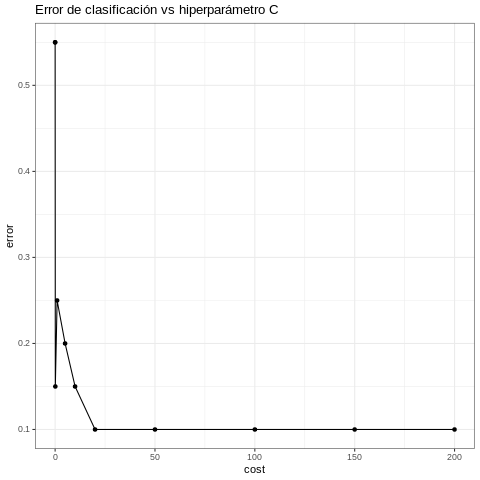

In [21]:
%%R
set.seed(1)
svm_cv <- tune("svm", y ~ X1 + X2, data = datos,
               kernel = 'linear',
               ranges = list(cost = c(0.001, 0.01, 0.1, 1, 5, 10, 20, 50, 100,
                                      150, 200)))
summary(svm_cv)

ggplot(data = svm_cv$performances, aes(x = cost, y = error)) +
  geom_line() +
  geom_point() +
  labs(title = "Error de clasificación vs hiperparámetro C") +
  theme_bw()

El proceso de cross-validation muestra que el valor de penalización con el que se consigue menor error rate es 20 o superior. La función ``tune()`` almacena el mejor modelo de entre todos los que se han comparado.\
Una vez obtenido el modelo final(usando ``$bestmodel``), se puede predecir la clase a la que pertenecen nuevas observaciones empleando la función ``predict()``.

In [34]:
%%R
mejor_modelo <- svm_cv$best.model
print(mejor_modelo)
# Datos de test simulados
set.seed(19)
coordenadas <- matrix(rnorm(40), 20, 2)
colnames(coordenadas) <- c("X1","X2")
y <- sample(c(-1,1), 20, rep = TRUE)
coordenadas[y == 1, ] <- coordenadas[y == 1, ] + 1

test <- data.frame(coordenadas, y)

# Predicciones
predicciones <- predict(object = mejor_modelo, test)
print(paste("Error de test:", 100*mean(test$y != predicciones),"%"))
table(predicción = predicciones, valor_real = test$y)


Call:
best.tune(method = "svm", train.x = y ~ X1 + X2, data = datos, ranges = list(cost = c(0.001, 
    0.01, 0.1, 1, 5, 10, 20, 50, 100, 150, 200)), kernel = "linear")


Parameters:
   SVM-Type:  C-classification 
 SVM-Kernel:  linear 
       cost:  20 

Number of Support Vectors:  6

[1] "Error de test: 15 %"
          valor_real
predicción -1  1
        -1 10  0
        1   3  7


### Ejercicio 1: Replicar todo el ejemplo en Python

##Máquinas de Vector Soporte
El Support Vector Classifier descrito en los apartados anteriores consigue buenos resultados cuando el límite de separación entre clases es aproximadamente lineal. Si no lo es, su capacidad decae drásticamente. Una estrategia para enfrentarse a escenarios en los que la separación de los grupos es de tipo no lineal consiste en expandir las dimensiones del espacio original.

El hecho de que los grupos no sean linealmente separables en el espacio original no significa que no lo sean en un espacio de mayores dimensiones. Las imágenes siguientes muestran como dos grupos, cuya separación en dos dimensiones no es lineal, sí lo es al añadir una tercera dimensión.

<div class="figure">
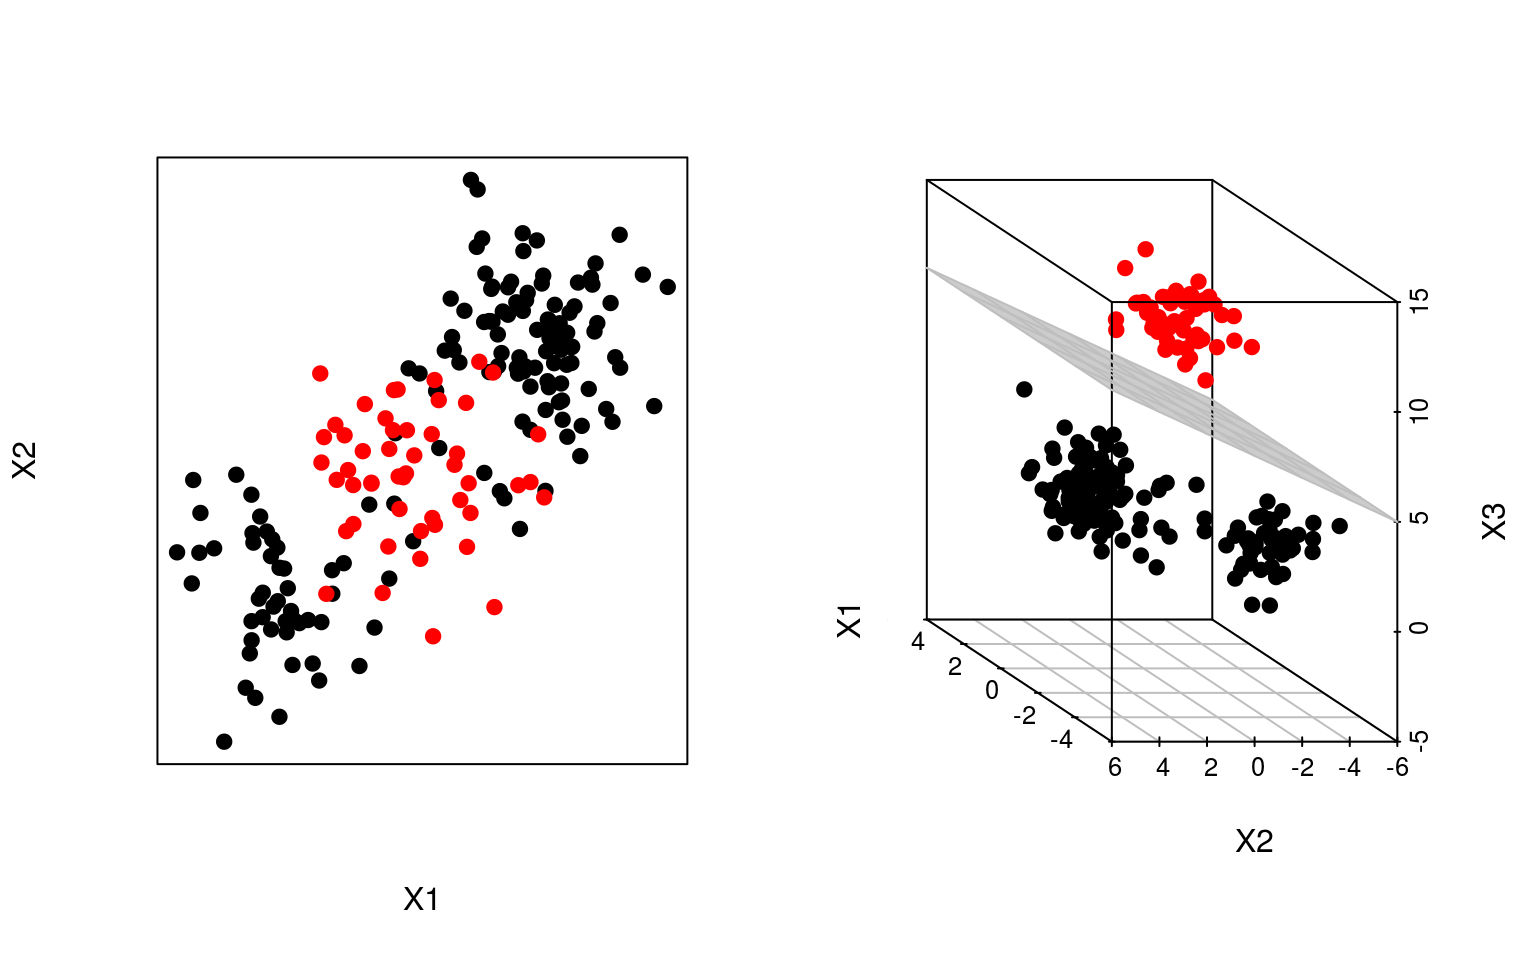


<div class="figure">
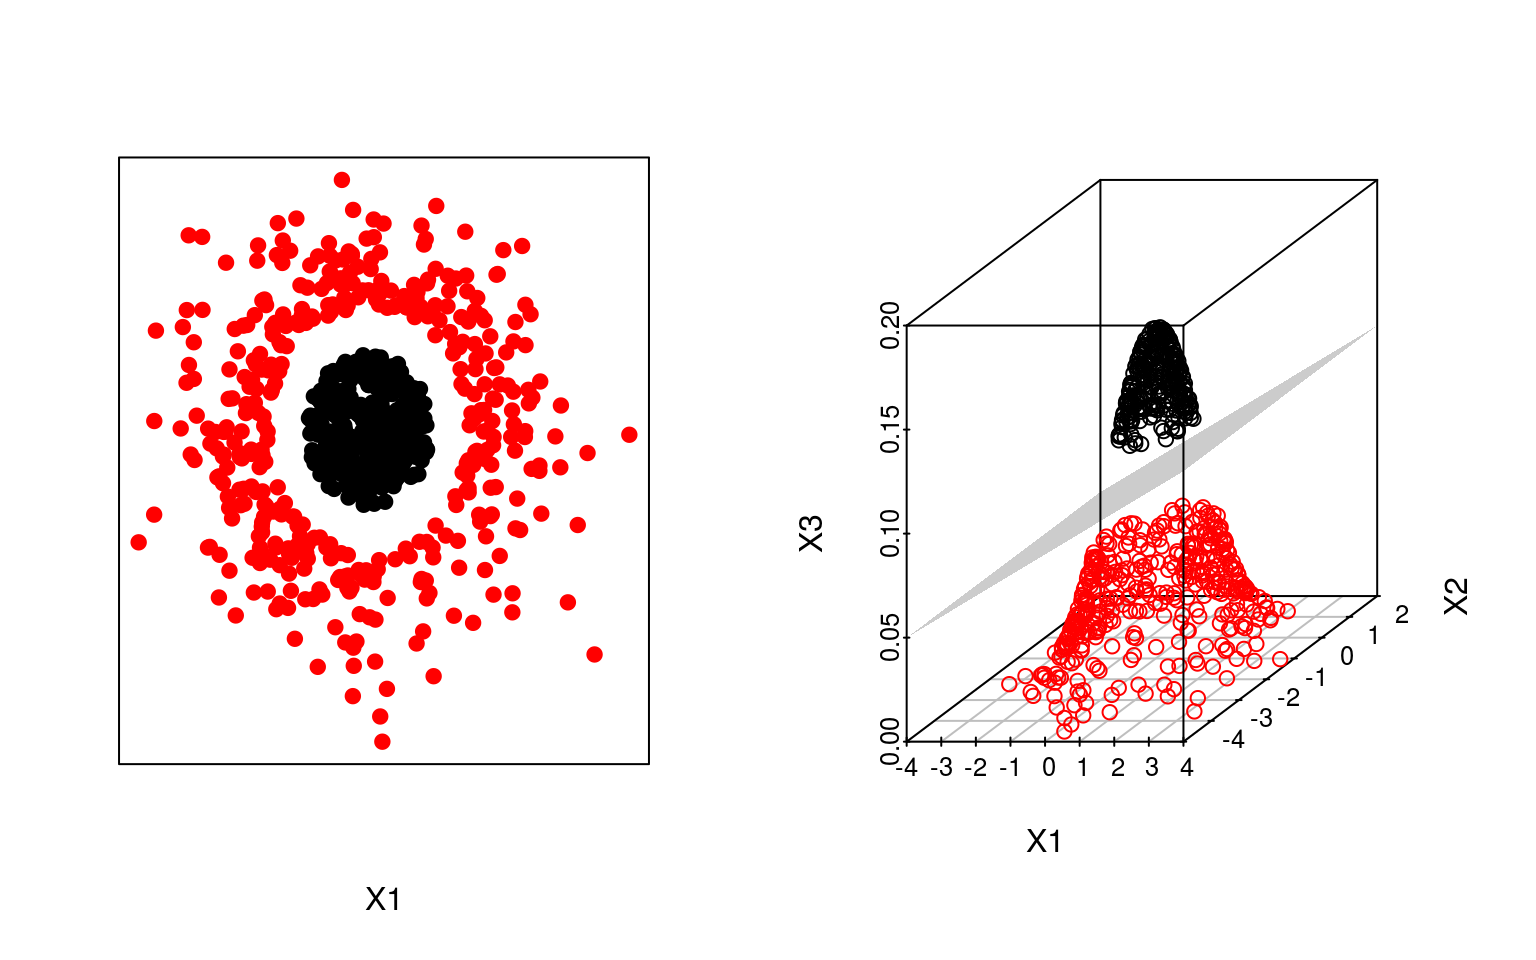

El método de Máquinas Vector Soporte (SVM) se puede considerar como una extensión del Support Vector Classifier obtenida al aumentar la dimensión de los datos. Los límites de separación lineales generados en el espacio aumentado se convierten en límites de separación no lineales al proyectarlos en el espacio original.

### Aumento en la dimensión, kernels
Una vez definido que las Máquinas de Vector Soporte siguen la misma estratégica que el Support Vector Classifier, pero aumentando la dimensión de los datos antes de aplicar el algoritmo, la pregunta inmediata es ¿Cómo se aumenta la dimensión y qué dimensión es la correcta?

La dimensión de un conjunto de datos puede transformarse combinando o modificando cualquiera de sus dimensiones. Por ejemplo, se puede transformar un espacio de dos dimensiones en uno de tres aplicando la siguiente función:
$$f(x_1,x_2) = (x_1^2, \sqrt{2}x_1x_2, x_2^2)$$

Esta es solo una de las infinitas trasformaciones posibles, ¿Cómo saber cuál es la adecuada? Es aquí donde los kernel entran en juego. Un kernel ($K$) es una función que devuelve el resultado del dot product entre dos vectores realizado en un nuevo espacio dimensional distinto al espacio original en el que se encuentran los vectores. Aunque no se ha entrado en detalle en las fórmulas matemáticas empleadas para resolver el problema de optimización, esta contiene un dot product (producto punto). Si se sustituye este dot product por un kernel, se obtienen directamente los vectores soporte (y el hiperplano) en la dimensión correspondiente al kernel. Ha esto se le suele conocer como kernel trick, porque, con solo una ligera modificación del problema original, gracias a los kernels, se puede obtener el resultado para cualquier dimensión. Existen multitud de kernels distintos, algunos de los más utilizados son:\
**Kernel lineal**\
$$K(\textbf{x}, \textbf{x'}) = \textbf{x} \cdot \textbf{x'}$$
Si se emplea un Kernel lineal, el clasificador *Support Vector Machine* obtenido es equivalente al *Support Vector Classifier*.

<div class="figure">
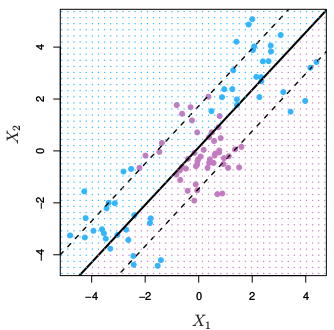


**Kernel polinómico**

$$K(\textbf{x}, \textbf{x'}) = (\textbf{x} \cdot \textbf{x'} + c) ^ d$$

Cuando se emplea $d=1$ y $c=0$, el resultado es el mismo que el de un kernel lineal. Si $d>1$, se generan límites de decisión no lineales, aumentando la no linealidad a medida que aumenta d. No suele ser recomendable emplear valores de $d$ mayores 5 por problemas de overfitting.

<div class="figure">
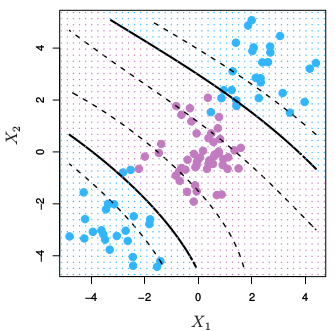


**Gaussian Kernel (RBF)**

$K(\textbf{x}, \textbf{x'}) = exp(- \gamma ||\textbf{x} - \textbf{x'}||^2)$

<div class="figure">
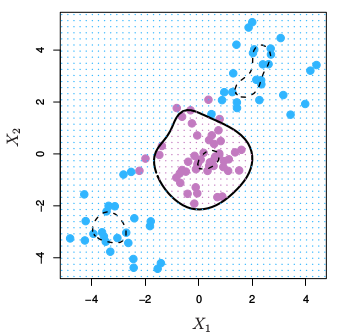


El valor de $\gamma$ controla el comportamiento del kernel, cuando es muy pequeño, el modelo final es equivalente al obtenido con un kernel lineal, a medida que aumenta su valor, también lo hace la flexibilidad del modelo.

Los kernels descritos son solo unos pocos de los muchos que existen. Cada uno tiene una serie de hiperparámetros cuyo valor óptimo puede encontrarse mediante validación cruzada. No puede decirse que haya un kernel que supere al resto, depende en gran medida de la naturaleza del problema que se esté tratando. Ahora bien, tal como indican los autores de *A Practical Guide to Support Vector Classification*, es muy recomendable probar el kernel RBF. Este kernel tiene dos ventajas: que solo tiene dos hiperparámetros que optimizar ($\gamma$ y la penalización $C$ común a todos los SVM) y que su flexibilidad puede ir desde un clasificador lineal a uno muy complejo.

<p>El problema de optimización cambia a </p>
<div class="math notranslate nohighlight">
 \begin{align}\begin{aligned}\min_{\alpha} \frac{1}{2} \alpha^T Q \alpha - e^T \alpha\\\begin{split}
\textrm {subject to } & y^T \alpha = 0\\
& 0 \leq \alpha_i \leq C, i=1, ..., n\end{split}\end{aligned}\end{align} </div>
<p>donde <span class="math notranslate nohighlight">\(e\)</span> es el vector de unos,
y <span class="math notranslate nohighlight">\(Q\)</span> es una matriz <span class="math notranslate nohighlight">\(n\)</span> por <span class="math notranslate nohighlight">\(n\)</span> positiva semidefinida,
<span class="math notranslate nohighlight">\(Q_{ij} \equiv y_i y_j K(x_i, x_j)\)</span>, donde <span class="math notranslate nohighlight">\(K(x_i, x_j) = \phi (x_i)^T \phi (x_j)\)</span>
es el kernel. Las <span class="math notranslate nohighlight">\(\alpha_i\)</span> se conocen como coeficientes duales y están acotadas por
 <span class="math notranslate nohighlight">\(C\)</span>.
 Esta representación dual hace notar el hecho de que los vectores de entrenamiento están implícitamente mapeando a un espacio de dimensión mayor por la función
 <span class="math notranslate nohighlight">\(\phi\)</span>: ver <a class="reference external" href="https://en.wikipedia.org/wiki/Kernel_method">kernel trick</a>.</p>
<p>Una vez que el problema de optimización es resuelto la 
<a class="reference internal" href="../glossary.html#term-decision_function"><span class="xref std std-term">función de decisión</span></a> para una muestra <span class="math notranslate nohighlight">\(x\)</span> se convierte en:</p>
<div class="math notranslate nohighlight">
$\sum_{i\in SV} y_i \alpha_i K(x_i, x) + b$,</div>
<p> y las clases predecidas corresponde a su signo. Sólo hay que sumar sobre su los vectores de soporte (los valores que caen en el margen)porque los coeficientes duales <span class="math notranslate nohighlight">\(\alpha_i\)</span> son cero para las otras observaciones.</p>

#### Ejemplo
Para el siguiente ejemplo se emplea un set de datos publicado en el libro Elements of Statistical Learning que contiene observaciones simuladas con una función no lineal en un espacio de dos dimensiones (2 predictores).



In [35]:
%%R
# Descargan los datos. Requiere conexión a internet
load(url("https://web.stanford.edu/~hastie/ElemStatLearn/datasets/ESL.mixture.rda"))
##El objeto ESL.mixture cargado es una lista que contiene almacenados el valor de los dos predictores en el elemento x y el valor de la clase a la que pertenece cada observación en el elemento y.

           X1         X2 y
1  2.52609297  0.3210504 0
2  0.36695447  0.0314621 0
3  0.76821908  0.7174862 0
4  0.69343568  0.7771940 0
5 -0.01983662  0.8672537 0
6  2.19654493 -1.0230141 0


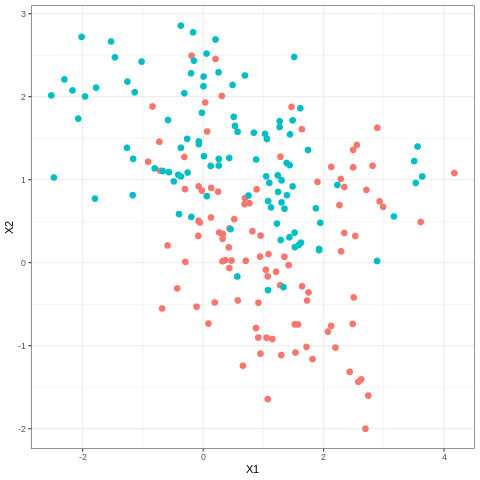

In [36]:
%%R
datos <- data.frame(ESL.mixture$x, y = ESL.mixture$y)
# Al tratarse de un problema de clasificación se convierte la variable
# respuesta en factor
datos$y <- as.factor(datos$y)
print(head(datos))

ggplot(data = datos, aes(x = X1, y = X2, color = y)) +
  geom_point(size =2.5) +
  theme_bw() +
  theme(legend.position = "none")

Entre los kernel no lineales que acepta la función ``svm()``destacan  ``kernel = "polinomial"``, en cuyo caso hay que indicar el grado del polinomio $d$, y ``kernel = "radial"``, en cuyo caso hay que indicar el hiperparámetro parámetro $\gamma$. Además de los hiperparámetros propios de cada kernel, todo SVM tiene también el hiperparámetro de penalización $C$.

Identificación de hiperparámetros óptimos y ajuste del modelo

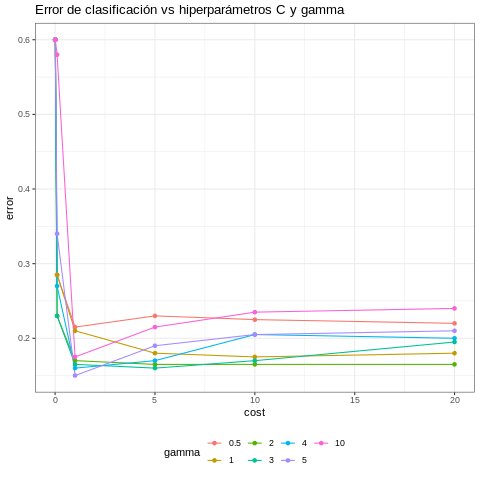

In [38]:
%%R
# Como los datos se han simulado en una misma escala, no es necesario estandarizarlos
# si no fuese así, es muy importante hacerlo.
set.seed(1)
svm_cv <- tune("svm", y ~ X1 + X2, data = datos, kernel = 'radial',
               ranges = list(cost = c(0.001, 0.01, 0.1, 1, 5, 10, 20),
                             gamma = c(0.5, 1, 2, 3, 4, 5, 10)))

ggplot(data = svm_cv$performances, aes(x = cost, y = error, color = as.factor(gamma)))+
  geom_line() +
  geom_point() +
  labs(title = "Error de clasificación vs hiperparámetros C y gamma", color = "gamma") +
  theme_bw() +
  theme(legend.position = "bottom")

[1] "mejores parámetros: 1" "mejores parámetros: 5"

Call:
best.tune(method = "svm", train.x = y ~ X1 + X2, data = datos, ranges = list(cost = c(0.001, 
    0.01, 0.1, 1, 5, 10, 20), gamma = c(0.5, 1, 2, 3, 4, 5, 10)), 
    kernel = "radial")


Parameters:
   SVM-Type:  C-classification 
 SVM-Kernel:  radial 
       cost:  1 

Number of Support Vectors:  133



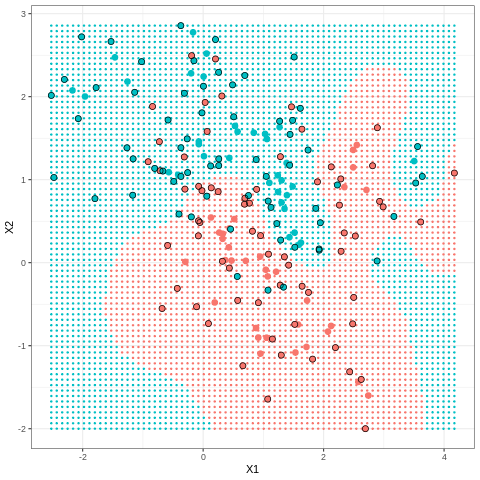

In [39]:
%%R
print(paste("mejores parámetros:",svm_cv$best.parameters))
modelo_svm_rbf <- svm_cv$best.model
print(modelo_svm_rbf)

# Se interpolar puntos dentro del rango de los dos predictores X1 y X2.
# Estos nuevos puntos se emplean para predecir la variable respuesta acorde
# al modelo y así colorear las regiones que separa el hiperplano.

# Rango de los predictores
rango_X1 <- range(datos$X1)
rango_X2 <- range(datos$X2)

# Interpolación de puntos
new_x1 <- seq(from = rango_X1[1], to = rango_X1[2], length = 75)
new_x2 <- seq(from = rango_X2[1], to = rango_X2[2], length = 75)
nuevos_puntos <- expand.grid(X1 = new_x1, X2 = new_x2)

# Predicción según el modelo de los nuevos puntos
predicciones <- predict(object = modelo_svm_rbf, newdata = nuevos_puntos)

# Se almacenan los puntos predichos para el color de las regiones en un dataframe
color_regiones <- data.frame(nuevos_puntos, y = predicciones)

ggplot() +
  # Representación de las 2 regiones empleando los puntos y coloreándolos
  # según la clase predicha por el modelo
  geom_point(data = color_regiones, aes(x = X1, y = X2, color = as.factor(y)),
             size = 0.5) +
  # Se añaden las observaciones
  geom_point(data = datos, aes(x = X1, y = X2, color = as.factor(y)),
             size = 2.5) +
  # Se identifican aquellas observaciones que son vectores soporte
  geom_point(data = datos[modelo_svm_rbf$index, ],
             aes(x = X1, y = X2, color = as.factor(y)),
             shape = 21, colour = "black",
             size = 2.5) +
  theme_bw() +
  theme(legend.position = "none")

### Ejercicio 2: Replica el ejemplo en Python

### *Support Vector Machines* para más de dos clases
El concepto de hiperplano de separación en el que se basan los SVMs no se generaliza de forma natural para más de dos clases. Se han desarrollado numerosas estrategias con el fin de aplicar este método de clasificación a situaciones con $k>2$-clases, de entre ellos, los más empleados son: one-versus-one, one-versus-all y DAGSVM.


**One-versus-one**

Supóngase un escenario en el que hay $K > 2$ clases y que se quiere aplicar el método de clasificación basado en SVMs. La estrategia de one-versus-one consiste en generar un total de $K(K-1)/2$ SVMs, comparando todos los posibles pares de clases. Para generar una predicción se emplean cada uno de los $K(K-1)/2$ clasificadores, registrando el número de veces que la observación es asignada a cada una de las clases. Finalmente, se considera que la observación pertenece a la clase a la que ha sido asignada con más frecuencia. La principal desventaja de esta estrategia es que el número de modelos necesarios se dispara a medida que aumenta el número de clases, por lo que no es aplicable en todos los escenarios.

Si a la función ``svm()`` recibe como variable respuesta un factor con más de dos niveles, realiza automáticamente una clasificación multi-clase empleando el método one-versus-one.

**DAGSVM**


DAGSVM (*Directed Acyclic Graph SVM*) es una mejora del método one-versus-one. La estrategia seguida es la misma, pero consiguen reducir su tiempo de ejecución eliminando comparaciones innecesarias gracias al empelo de una directed acyclic graph (DAG). Supóngase un set de datos con cuatro clases (A, B, C, D) y 6 clasificadores entrenados con cada posible par de clases (A-B, A-C, A-D, B-C B-D, C-D). Se inician las comparaciones con el clasificador (A-D) y se obtiene como resultado que la observación pertenece a la clase A, o lo que es equivalente, que no pertenece a la clase D. Con esta información se pueden excluir todas las comparaciones que contengan la clase D, puesto que se sabe que no pertenece a este grupo. En la siguiente comparación se emplea el clasificador (A-C) y se predice que es A. Con esta nueva información se excluyen todas las comparaciones que contengan C. Finalmente solo queda emplear el clasificador (A-B) y asignar la observación al resultado devuelto. Siguiendo esta estrategia, en lugar de emplear los 6 clasificadores, solo ha sido necesario emplear 3. DAGSVM tiene las mismas ventajas que el método one-versus-one pero mejorando mucho el rendimiento.

#### Ejemplo
El set de datos ``khan`` contiene información sobre 83 muestras pertenecientes a 4 tipos distintos de tumores. Para cada una de las muestras se dispone del perfil de expresión de 2308 genes. Se pretende crear un clasificador multiclase basado en SVMs que permita predecir el tipo de tumor en función de la expresión de los genes. El set de datos está dividido en training set (``xtrain``, ``ytrain``) y test set (``xtest``, ``ytest``), 63 observaciones destinadas a entrenamiento y 20 a la evaluación del modelo.



In [7]:
%%R

data("Khan")
print(names(Khan))

print(dim(Khan$xtrain))
print(dim(Khan$xtest))
print(length(Khan$ytrain))
print(length(Khan$ytest))




[1] "xtrain" "xtest"  "ytrain" "ytest" 
[1]   63 2308
[1]   20 2308
[1] 63
[1] 20


En este tipo de escenario, en el que el número de predictores es varios órdenes de magnitud mayor que el de observaciones, los modelos son proclives a sufrir *overfitting*. Esto sugiere que, de entre los diferentes tipos de kernels, sea adecuado emplear el de menor flexibilidad, el kernel lineal. El único hiperparámetro de un SVM con kernel lineal es el valor de penalización $C$.



In [8]:
%%R
# Como la variable respuesta está separa de los predictores, se unen en un único 
# dataframe. La variable respuesta tiene que ser de tipo factor.
datos_train <- data.frame( y = as.factor(Khan$ytrain), Khan$xtrain)

svm_cv <- tune("svm", y ~ ., data = datos_train, kernel = 'linear',
               ranges = list(cost = c(0.0001, 0.0005, 0.001, 0.01, 0.1, 1)))

ggplot(data = svm_cv$performances, aes(x = cost, y = error)) +
  geom_line() +
  geom_point() +
  labs(title = "Error de clasificación vs hiperparámetro C") +
  theme_bw()


  print(svm_cv$best.parameters)

  modelo_svm <- svm_cv$best.model
print(modelo_svm)

print(table(prediccion = modelo_svm$fitted, clase_real = datos_train$y))
# Aciertos del modelo con los datos de entrenamiento
print(paste("Error de entrenamiento:", 100*mean(datos_train$y != modelo_svm$fitted), "%"))

   cost
2 5e-04

Call:
best.tune(method = "svm", train.x = y ~ ., data = datos_train, ranges = list(cost = c(1e-04, 
    5e-04, 0.001, 0.01, 0.1, 1)), kernel = "linear")


Parameters:
   SVM-Type:  C-classification 
 SVM-Kernel:  linear 
       cost:  5e-04 

Number of Support Vectors:  58

          clase_real
prediccion  1  2  3  4
         1  8  0  0  0
         2  0 23  0  0
         3  0  0 12  0
         4  0  0  0 20
[1] "Error de entrenamiento: 0 %"


El modelo obtenido tiene un training error del 0%, es capaz de clasificar correctamente todas las observaciones empleadas para crearlo. Un training error muy bajo puede ser un indicativo de overfitting, lo que haría que el modelo no fuese capaz de predecir correctamente nuevas observaciones. Para evaluar si es este el caso, se emplea el modelo para predecir las 20 observaciones del test set.

In [9]:
%%R
datos_test <- data.frame(y = as.factor(Khan$ytest), Khan$xtest)
predicciones <- predict(object = modelo_svm, newdata = datos_test)

print(paste("Error de test:", 100 * mean(datos_test$y != predicciones), "%"))

print(table(prediccion = predicciones, clase_real = datos_test$y))

[1] "Error de test: 10 %"
          clase_real
prediccion 1 2 3 4
         1 3 0 0 0
         2 0 6 0 0
         3 0 0 4 0
         4 0 0 2 5


De las 20 observaciones de test, el modelo SVM con ``kernel = "linear"`` y ``cost = 10`` predice correctamente 18 y falla en 2, su test error es solo del 10%.

### Ejercicio 3: Pasar ejemplo multiclase a Python